In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [2]:
TIME_STEP = 1/1000

In [3]:
class Plant:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        ax += self.noise[0]
        ay += self.noise[1]
        az += self.noise[2]
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP**2
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP**2
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP**2
        self.__vx += ax*TIME_STEP
        self.__vy += ay*TIME_STEP
        self.__vz += az*TIME_STEP
        return self.__x, self.__y, self.__z

In [4]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.disable_integral = False
        self.ierr = 0
        self.__prev_err = 0
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = 0 if self.disable_integral else self.ierr + err*TIME_STEP
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

In [5]:
class Target:
    
    def __init__(self, scale=1, momentum=0.5):
        self.__plant = Plant(noise_scale=0)
        self.__scale = scale
        self.__momentum = momentum
        self.__a = np.zeros((3,))
    
    def step(self):
        self.__a = self.__a*self.__momentum + \
            (1-self.__momentum)*np.random.randn(3)
        return self.__plant.step(*self.__a*self.__scale)

final noise -4.842184711122352 0.275373277558691 1.1889907512807252
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.02611850846252395 -0.043354267929239576 0.10698889234004483


<IPython.core.display.Javascript object>


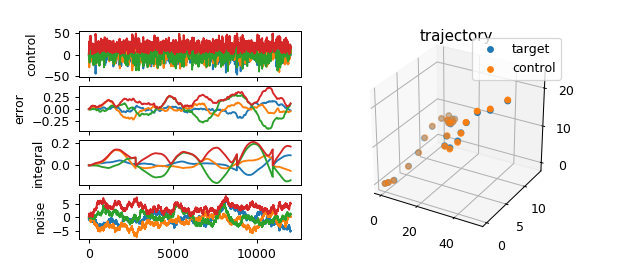

In [6]:
Kp,Ki,Kd = 10,100,35
control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
pid_x, pid_y, pid_z = [PIDController(Kp,Ki,Kd) for _ in range(3)]
x,y,z = plant.step(0,0,0)
T, Y, C, E, I, N = [[] for _ in range(6)]
for t in range(12000):
    tx,ty,tz = target.step()
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    clen = np.linalg.norm((cx,cy,cz))
    pid_x.disable_integral = \
    pid_y.disable_integral = \
    pid_z.disable_integral = clen > control_max
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((tx-x,ty-y,tz-z,np.linalg.norm((tx-x,ty-y,tz-z))))
    I.append((pid_x.ierr,pid_y.ierr,pid_z.ierr,np.linalg.norm((pid_x.ierr,pid_y.ierr,pid_z.ierr))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

In [7]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [46]:
class PIDCell(keras.layers.Layer):
    
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        super(PIDCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.built = True
    
    def call(self, inputs, states):
        dt, err, Kp, Ki, Kd, reset_integral = \
            inputs[:,0:1],inputs[:,1:self.units+1], \
            inputs[:,self.units+1:self.units+2],inputs[:,self.units+2:self.units+3], \
            inputs[:,self.units+3:self.units+4],inputs[:,self.units+4:self.units+5]
        perr, ierr = states
        ierr_gate = K.print_tensor(1-K.sigmoid(reset_integral), message='ierr_gate: ')
        Kp = K.print_tensor(K.softplus(Kp), message='Kp: ')
        Ki = K.print_tensor(K.softplus(Ki), message='Ki: ')
        Kd = K.print_tensor(K.softplus(Kd), message='Kd: ')
        ierr = ierr_gate*(ierr+err*dt)
        derr = (err-perr)/dt
        perr = err
        return Kp*err + Ki*ierr + Kd*derr, [perr, ierr]

In [47]:
X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X_input_tar = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar])
X = keras.layers.LSTM(64, stateful=True, return_sequences=True)(X)
X_Kp = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Ki = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Kd = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_reset_integral = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X = keras.layers.Concatenate()([X_input_dt,X_input_err,X_Kp,X_Ki,X_Kd,X_reset_integral])
X_pid,_,X_ierr = keras.layers.RNN(PIDCell(3), stateful=True, return_sequences=True, return_state=True)(X)
M_control = keras.Model([X_input_dt,X_input_err,X_input_tar], X_pid)
M_control.compile('adam', 'mse')
M_control_freeze = keras.Model([X_input_dt,X_input_err,X_input_tar], [X_pid,X_ierr])
M_control_freeze.trainable = False
M_control_freeze.compile('adam', 'mse')
M_control.summary()

X_input_ctl = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar,X_input_ctl])
X = keras.layers.LSTM(64, stateful=True, return_sequences=True)(X)
X = keras.layers.TimeDistributed(keras.layers.Dense(3, kernel_initializer='he_normal'))(X)
M_plant = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant.compile('adam', 'mse')
M_plant_freeze = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant_freeze.trainable = False
M_plant_freeze.compile('adam', 'mse')
M_plant.summary()

X = M_control([X_input_dt,X_input_err,X_input_tar])
X = M_plant_freeze([X_input_err,X_input_tar,X])
M_train = keras.Model([X_input_dt,X_input_err,X_input_tar], X)
M_train.compile('adam', 'mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (1, 1, 3)            0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (1, 1, 3)            0                                            
__________________________________________________________________________________________________
concatenate_26 (Concatenate)    (1, 1, 6)            0           input_39[0][0]                   
                                                                 input_40[0][0]                   
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (1, 1, 64)           18176       concatenate_26[0][0]             
__________

final noise 0.7258190362380109 3.8959373803278567 1.1963653509576868
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.1161591944781577 0.21064492076980912 -0.07467608767822043


<IPython.core.display.Javascript object>


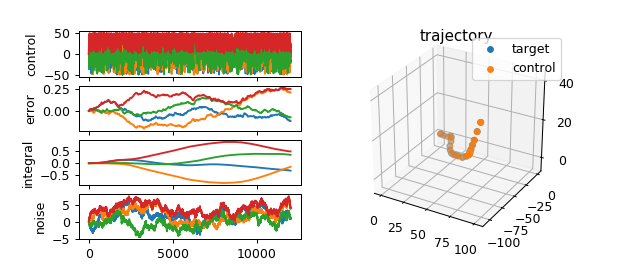

plant model loss [0.00010584627307252958]
trainning model loss [0.02302088774740696]
final noise -0.6968611058355555 -0.351335528787041 5.026335956396012
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.11826191991026747 0.031004404879476866 0.172151631686706


<IPython.core.display.Javascript object>


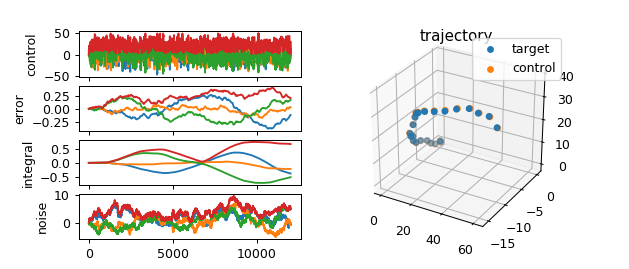

plant model loss [5.1021477702306584e-05]
trainning model loss [0.015312234871089458]
final noise -0.1002145662996458 -3.0594805981121316 -2.673376066758861
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.7712951390724694 -0.025959766194894485 0.03406093908816388


<IPython.core.display.Javascript object>


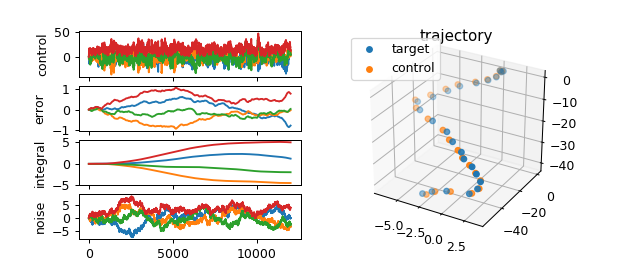

plant model loss [0.005178718827664852]
trainning model loss [0.10450641065835953]
final noise 3.0349435088458003 0.07612903106730119 2.374336917274717
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 1.2863479212398374 1.5255071083724374 -2.142397804096298


<IPython.core.display.Javascript object>


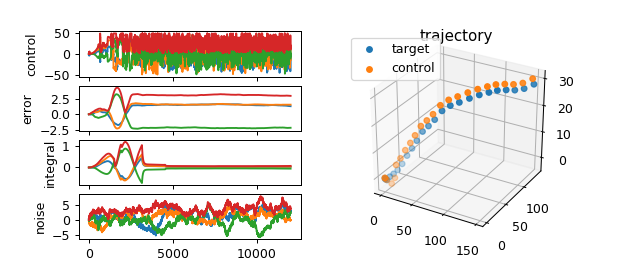

plant model loss [0.004518414847552776]
trainning model loss [2.7554309368133545]
final noise -0.7814956966440223 2.9057525091075704 1.3152328408635612
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -3.0455681205908576 9.440971293784578 3.6651838920871214


<IPython.core.display.Javascript object>


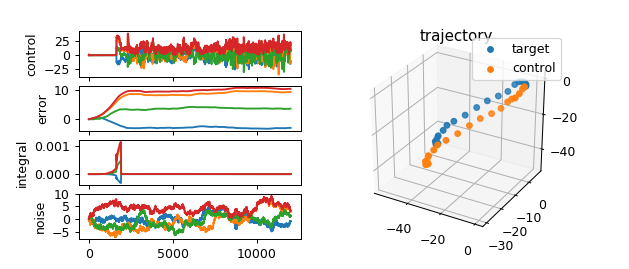

plant model loss [0.0007828591042198241]
trainning model loss [10.342952728271484]
final noise -2.13157868907975 2.0195047219135662 2.188288413534253
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -4.63950859424186 -0.1941308517717033 -2.898659055825327


<IPython.core.display.Javascript object>


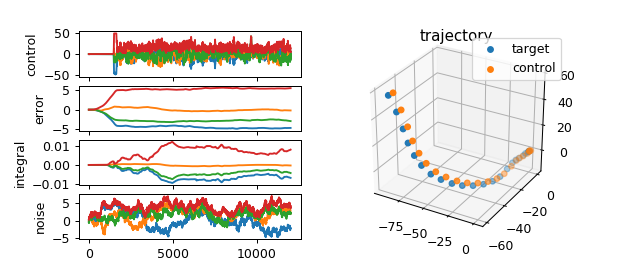

plant model loss [0.0007056252215988934]
trainning model loss [1.7301464080810547]
final noise -2.4944673644185817 -0.29363138313361986 -2.706718146225737
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 1.0616364935607123 1.8851879972717356 -1.5983356944271776


<IPython.core.display.Javascript object>


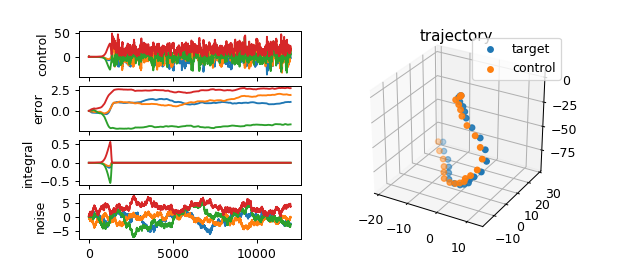

plant model loss [0.00036840923712588847]
trainning model loss [2.384315013885498]
final noise 1.5485310731708513 4.772239646054266 0.0012676045774057398
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.8775090113573611 -5.90000522510527 -3.3898633086787484


<IPython.core.display.Javascript object>


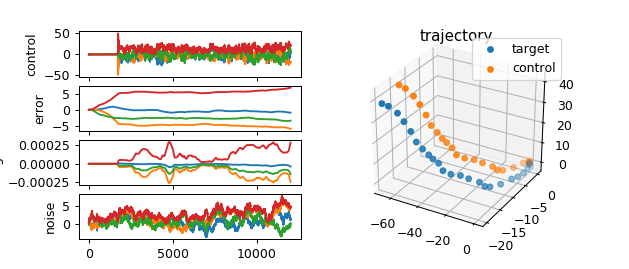

plant model loss [0.00011843186803162098]
trainning model loss [0.4663924276828766]
final noise 3.0502218555160803 3.373065927364376 -0.7991419385026419
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 4.496283326122395 0.7254040103352821 1.1981314625774644


<IPython.core.display.Javascript object>


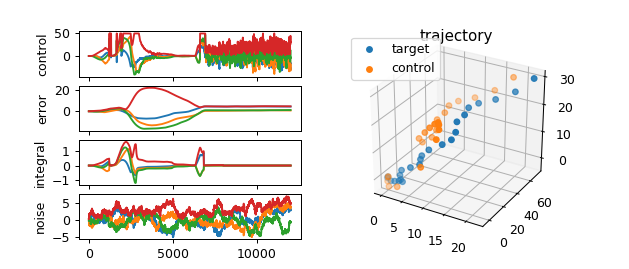

plant model loss [0.005631334614008665]
trainning model loss [7.078119277954102]
final noise -0.549329482362232 -0.3546374081829058 1.2087776449616436
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 6.651071247213551 -0.3041787097481885 5.584000375481594


<IPython.core.display.Javascript object>


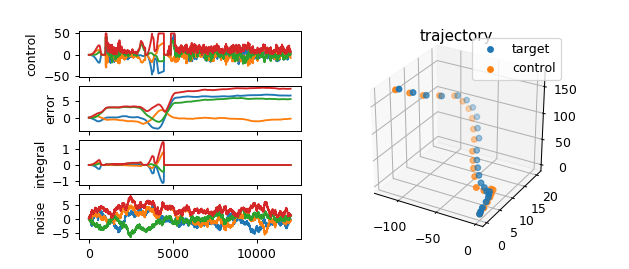

plant model loss [4.5075517846271396e-05]
trainning model loss [17.12961769104004]
1min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [49]:
%%timeit -n 10 -r 1

control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
x,y,z = plant.step(0,0,0)
ex,ey,ez = 0,0,0
T, Y, C, E, I, N = [[] for _ in range(6)]
M_control_freeze.reset_states()
for t in range(12000):
    tx,ty,tz = target.step()
    ctl,ierr = M_control_freeze.predict([
        np.array([[[TIME_STEP]]]),
        np.array([[[ex,ey,ez]]]),
        np.array([[[tx,ty,tz]]])-np.array([[[x,y,z]]])])
    cx,cy,cz = ctl[0,0]
    iex,iey,iez = ierr[0]
    clen = np.linalg.norm((cx,cy,cz))
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    ex,ey,ez = tx-x,ty-y,tz-z
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((ex,ey,ez,np.linalg.norm((ex,ey,ez))))
    I.append((iex,iey,iez,np.linalg.norm((iex,iey,iez))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', ex, ey, ez)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

M_plant.reset_states()
for e,t,y,c,l in zip(E[:-1], T[1:], Y[:-1], C[1:], E[1:]):
    history = M_plant.fit(
        [np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]]),np.array([[c[:3]]])],
        np.array([[l[:3]]]), batch_size=1, shuffle=False, verbose=0)
print('plant model loss', history.history['loss'])

M_train.reset_states()
for e,t,y in zip(E[:-1], T[1:], Y[:-1]):
    history = M_train.fit(
        [np.array([[[TIME_STEP]]]),np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]])],
        np.array([[[0,0,0]]]), batch_size=1, shuffle=False, verbose=0)
print('trainning model loss', history.history['loss'])